# Solution Assignment 4: SVHN Competition

This is the solution for the fifth assignment of the Implementing Artificial Neural Networks with TensorFlow course. Please find the according assignment sheet on studip.

The presented network reaches a validation accuarcy of ~90% in only 2:30 minutes training time on a GPU and in about 10 to 20 minutes on a CPU with only 3 epochs of training.

## Imports
We are going to use `tensorflow` to implement the neural network, `numpy` for the preparation of our training data and `matplotlib` to plot the training process. The `scipy.io` library is required to read the SVHN files and `os` is required to join directory paths. Finally, we activate inline plotting by calling `%matplotlib notebook`.

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import scipy.io as scio

%matplotlib notebook

## The SVHN helper class
This class loads the SVHN training and test data and converts it into grayscale images. Further, 10% of the training data are seperated into a validation data set. The class provides three methods to iterate over the training, validation and test data respectively. If batch_size is set to a value <= 0, the method returns all data and labels at once.

In [8]:
class SVHN():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = np.array([])
        self._training_labels = np.array([])
        self._test_data = np.array([])
        self._test_labels = np.array([])
        
        self._load_traing_data()
        self._load_test_data()
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    
    def _load_traing_data(self):
        self._training_data, self._training_labels = self._load_data("train_32x32.mat")        
    
    def _load_test_data(self):
        self._test_data, self._test_labels = self._load_data("test_32x32.mat")
    
    def _rgb2gray(self, rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    def _load_data(self, file):
        path = os.path.join(self._directory, file)
        
        mat = scio.loadmat(path)
        data = np.moveaxis(mat["X"], 3, 0)
        data = self._rgb2gray(data)
        data = data.reshape(data.shape + (1,))
        
        labels = mat["y"].reshape(mat["y"].shape[0])
        labels[labels == 10] = 0
        
        return data, labels
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    
    

## Creating a new SVHN instance

Since the SVHN class reads the SVHN data every time we create a new instance, we are going to create a single instance here and reuse it in the cells bellow.

This script assumes, that the SVHN data files are located in a subdirectory named "data".


In [9]:
svhn = SVHN("./data")

TypeError: 'NoneType' object is not iterable

## Investigating the data
Before we start to use the data we should always try to understand its structure and double check, that data and labels are assigned correctly. Therefore, we plot some samples and the respective labels.

<IPython.core.display.Javascript object>


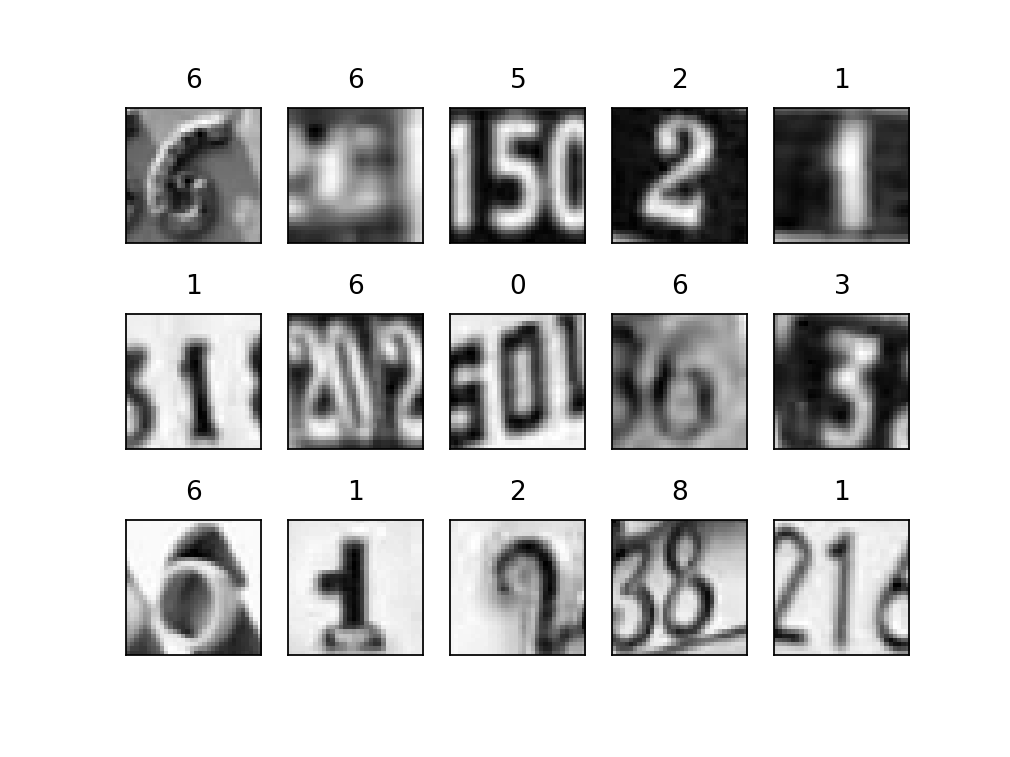

In [4]:
images, labels = next(svhn.get_training_batch(25))

fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.matshow(images[i, : , :, 0], cmap = "gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(labels[i])

## Helper functions
Next, we create a bunch of helper functions that ease the creation of complex deep networks. A function for feed forward layers, a function for convolutional layers, a function for batch normalization, a function for a residual block and finally a function to flatten feature maps into an array.

In [5]:
def feed_forward_layer(x, target_size, activation_function = None):
    print("Forward-Layer:" + str(x.shape))
    
    fan_in = int(x.shape[-1])
    
    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)
    
    activation = tf.matmul(x, weights) + biases
    
    return activation if activation_function is not callable else activation_function(activation)


def conv_layer(x, kernel_quantity, kernel_size, stride_size, normalize = False, activation_function = False):
    print("Conv-Layer:" + str(x.shape))
    depth = x.shape[-1]
    fan_in = int(x.shape[1] * x.shape[2])
    
    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, depth, kernel_quantity], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [kernel_quantity], initializer = var_init)
    
    activation = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    
    if normalize:
        activation = batch_norm(activation)
    
    return activation if activation_function is not callable else activation_function(activation)


def _pop_batch_norm(x, pop_mean, pop_var, offset, scale):
    return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, 1e-6)

def _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale):
    decay = 0.99
    
    dependency_1 = tf.assign(pop_mean, pop_mean * decay + mean * (1 - decay))
    dependency_2 = tf.assign(pop_var, pop_var * decay + var * (1 - decay))

    with tf.control_dependencies([dependency_1, dependency_2]):
        return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

def batch_norm(x):
    depth = x.shape[-1]
    mean, var = tf.nn.moments(x, axes = [0, 1, 2])
    
    var_init = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [depth], tf.float32, var_init)
    var_init = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [depth], tf.float32, var_init)
    
    pop_mean = tf.get_variable("pop_mean", [depth], initializer = tf.zeros_initializer(), trainable = False)
    pop_var = tf.get_variable("pop_var", [depth], initializer = tf.ones_initializer(), trainable = False)
    
    return tf.cond(
        is_training,
        lambda: _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale),
        lambda: _pop_batch_norm(x, pop_mean, pop_var, offset, scale)
    )


def residual_layer(x, kernelQuantity, kernelSize, strideSize):
    with tf.variable_scope("conv1"):
        layer_1 = conv_layer(x, kernelQuantity, kernelSize, strideSize, True, tf.nn.relu)
    with tf.variable_scope("conv2"):
        layer_2 = conv_layer(layer_1, kernelQuantity, kernelSize, strideSize, True)

    return tf.nn.relu(layer_2 + x)


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])

## Construction phase
In the construction phase we use the helper function to create a complex deep network. The `is_training` placeholder indicates, if in batch normalization stages, the mean and variance of the batch should be used or the estimated population mean and variance. Different layers of the network are encapsulated into their own namespaces.

The network consists of 9 convolutional and 2 fully connected layers and has the following structure:

![PICTURE MISSING](svhn_network-structure.png)





In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 32, 32, 1])
desired = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool, None)

with tf.variable_scope("normalize-1"):
    mean, var = tf.nn.moments(x, axes = [0, 1, 2])
    x_normalized = x - mean

with tf.variable_scope("layer-1"):
    layer_1 = conv_layer(x_normalized, 16, 7, 2, True, tf.nn.relu)

with tf.variable_scope("layer-2"):
    layer_2 = residual_layer(layer_1, 16, 3, 1)

with tf.variable_scope("layer-3"):
    layer_3 = conv_layer(layer_2, 32, 3, 2, True, tf.nn.relu)
    
with tf.variable_scope("layer-4"):
    layer_4 = residual_layer(layer_3, 32, 3, 1)

with tf.variable_scope("layer-5"):
    layer_5 = conv_layer(layer_4, 32, 3, 2, True, tf.nn.relu)
    
with tf.variable_scope("layer-6"):
    layer_6 = residual_layer(layer_5, 32, 3, 1)

with tf.variable_scope("normalize-2"):
    residual_network_out = batch_norm(layer_6)

with tf.variable_scope("hidden-layer"):
    flat = flatten(residual_network_out)
    hidden_layer = feed_forward_layer(flat, 512, tf.nn.relu)

with tf.variable_scope("output-layer"):
    logits = feed_forward_layer(hidden_layer, 10)


Conv-Layer:(?, 32, 32, 1)
Conv-Layer:(?, 16, 16, 16)
Conv-Layer:(?, 16, 16, 16)
Conv-Layer:(?, 16, 16, 16)
Conv-Layer:(?, 8, 8, 32)
Conv-Layer:(?, 8, 8, 32)
Conv-Layer:(?, 8, 8, 32)
Conv-Layer:(?, 4, 4, 32)
Conv-Layer:(?, 4, 4, 32)
Forward-Layer:(?, 512)
Forward-Layer:(?, 512)


## Learning rate scheduling, loss and accuracy
A piecewise constant learning rate scheduling is used to speed up learning. Then, the cross entropy, optimizer and accuracy are defined as usual.

In [7]:
with tf.variable_scope("learning-rate-scheduling"):
    global_step = tf.Variable(0, trainable = False)
    boundaries = [250, 350, 450, 550]
    learning_rates = [1e-3, 8e-4, 6e-4, 2e-4, 1e-4]
    learning_rate = tf.train.piecewise_constant(global_step, boundaries, learning_rates)


with tf.variable_scope("cross-entropy"):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = desired, logits = logits)
    cross_entropy = tf.reduce_mean(cross_entropy)


with tf.variable_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_step = optimizer.minimize(cross_entropy, global_step = global_step)


with tf.variable_scope("accuracy"):
    accuracy = tf.equal(tf.argmax(tf.nn.softmax(logits), 1), desired)
    accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

## Hyperparameters
The network is trained for three epochs with a batch size of 300.

In [8]:
epochs = 3
mini_batch_size = 300
plot_step_size = 25
training_steps = svhn.get_sizes()[0] // mini_batch_size

<IPython.core.display.Javascript object>


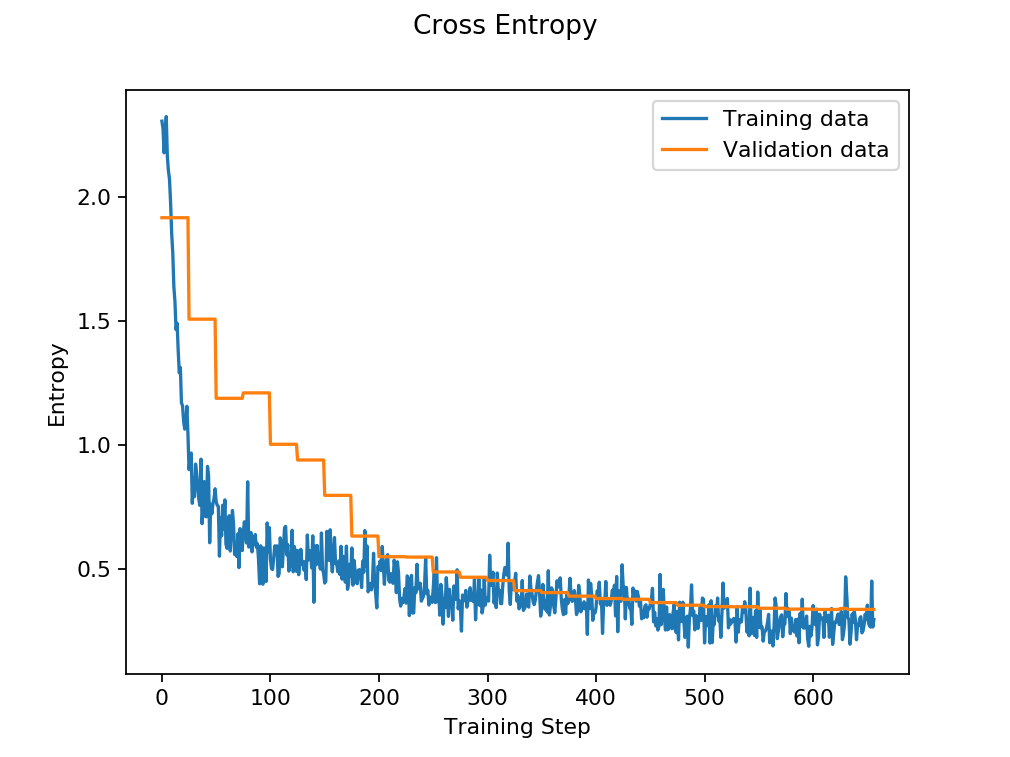

<IPython.core.display.Javascript object>


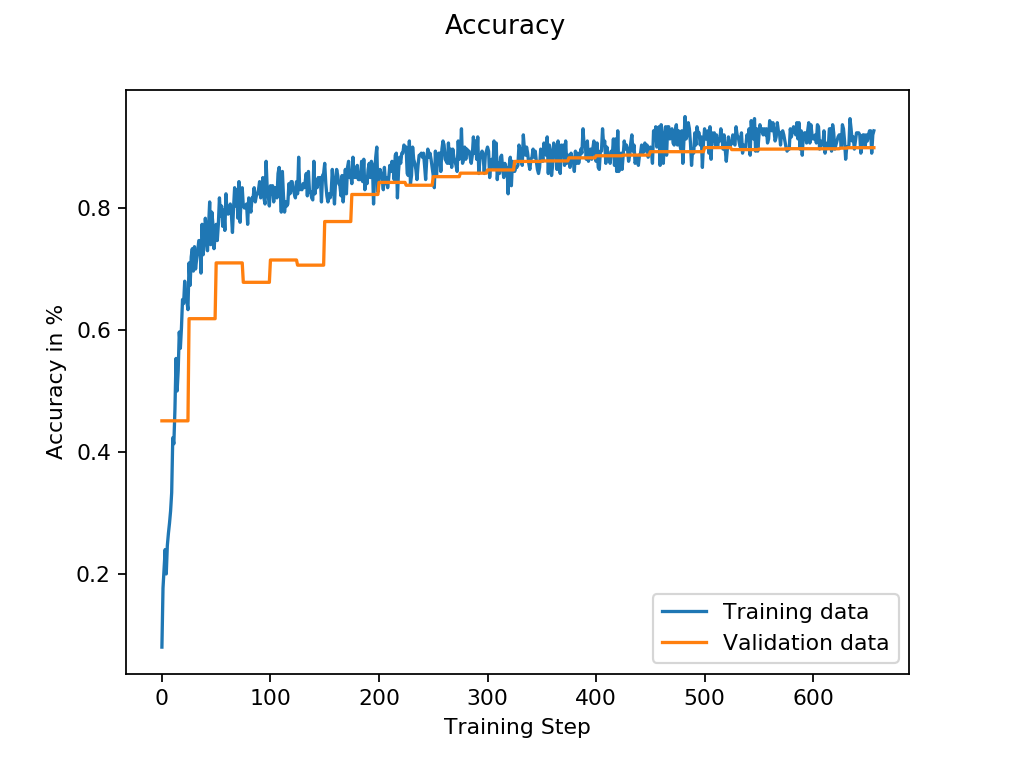

In [9]:
training_cross_entropies = np.zeros(training_steps * epochs)
validation_cross_entropies = np.zeros(training_steps * epochs)

training_accuracies = np.ones(training_steps * epochs)
validation_accuracies = np.ones(training_steps * epochs)

fig_cross_entropy, ax_cross_entropy = plt.subplots()
fig_cross_entropy.suptitle("Cross Entropy")

fig_accuracy, ax_accuracy = plt.subplots()
fig_accuracy.suptitle("Accuracy")

In [10]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    step = 0
    last_step = False
    for epoch in range(epochs):
        for images, labels in svhn.get_training_batch(mini_batch_size):
                
            training_cross_entropies[step], training_accuracies[step], _, = session.run(
                [cross_entropy, accuracy, training_step],
                feed_dict = {x: images, desired: labels, is_training: True}
            )
            
            if step == (training_steps * epochs)-1:
                last_step = True
            
            if step % plot_step_size == 0 or last_step:
                saver.save(session, "./weights/resnet.checkpoint", step)
                
                images, labels = next(svhn.get_validation_batch(0))
                
                validation_cross_entropy, validation_accuracy = session.run(
                    [cross_entropy, accuracy],
                    feed_dict = {x: images, desired: labels, is_training: False}
                )
                
                if step != 0:
                    on = step - plot_step_size if not last_step else step - plot_step_size + 1
                    off = on + plot_step_size
                    validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                    validation_accuracies[on:off] = [validation_accuracy] * plot_step_size
                
                ax_cross_entropy.cla()
                ax_cross_entropy.plot(training_cross_entropies, label = "Training data")
                ax_cross_entropy.plot(validation_cross_entropies, label = "Validation data")
                ax_cross_entropy.set_xlabel("Training Step")
                ax_cross_entropy.set_ylabel("Entropy")
                ax_cross_entropy.legend()
                fig_cross_entropy.canvas.draw()
                
                ax_accuracy.cla()
                ax_accuracy.plot(training_accuracies, label = "Training data")
                ax_accuracy.plot(validation_accuracies, label = "Validation data")
                ax_accuracy.set_xlabel("Training Step")
                ax_accuracy.set_ylabel("Accuracy in %")
                ax_accuracy.legend()
                fig_accuracy.canvas.draw()
                
            step += 1

print(validation_accuracies[-1])

0.898976266384


## Testing the network
Finally, the network is tested with the test data. To simulate a real world inference step, each images is fed into the network one by one. The test accuracy of the network is a little about 90%.

In [11]:
with tf.Session() as session:
    saver = tf.train.Saver()
    saver.restore(session,  tf.train.latest_checkpoint("./best/"))
    
    test_accuracy = 0
    for step, (images, labels) in enumerate(svhn.get_test_batch(1)):
        test_accuracy += session.run(
            accuracy,
            feed_dict = {x: images, desired: labels, is_training: False}
        )
    
print("Test Accuracy: " + str(test_accuracy / step))    

INFO:tensorflow:Restoring parameters from ./best/resnet.checkpoint-875
Test Accuracy: 0.904383235373


This solution is brought to you by Lukas Braun. If you have any questions or comments, please do not hesitate to contact lbraun@uos.de